# Enhanced K-Nearest Neighbors Regression - Real Estate Price Prediction

This notebook builds an improved K-Nearest Neighbors (KNN) regression model to predict property prices (price_per_m2) using the processed alonhadat dataset. We'll implement several enhancements to improve the model's performance:

1. Better feature selection and engineering
2. Advanced outlier handling
3. Expanded hyperparameter tuning
4. Optimized distance metrics
5. Feature importance analysis

## 1. Import Libraries

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

## 2. Load Data

In [73]:
# Load the preprocessed data
df = pd.read_csv('../../Data Preprocessing/alonhadat_processed.csv')

# Display basic information
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
df.head()

Dataset shape: (14415, 16)

First few rows:


,address,area,bedrooms,date,floors,price,title,road,ward,district,address_complete,road_cat,ward_cat,district_cat,price_converted,price_per_m2
0,"Đường Nguyễn Văn Cừ, Phường Gia Thụy, Quận Lon...",80,1,Hôm nay,1,"7,5 tỷ","🥇ĐẤT NGUYỄN VĂN CỪ 80M, MT8M, MẢNH ĐẤT RỘNG TH...",Nguyễn Văn Cừ,Gia Thụy,Long Biên,1,564,54,11,7500.00,93.75
1,"Đường Ngọc Lâm, Phường Ngọc Lâm, Quận Long Biê...",36,3,Hôm nay,6,"8,65 tỷ","🔥CÒN DUY NHẤT 1 CĂN GIÁ RẺ, NGỌC LÂM 36M, 6T G...",Ngọc Lâm,Ngọc Lâm,Long Biên,1,603,157,11,8650.00,240.28
2,"Đường Ngô Gia Tự, Phường Đức Giang, Quận Long ...",56,1,Hôm nay,1,"15,5 tỷ","👉MẶT PHỐ, NGÔ GIA TỰ, 56M, MT4M, VỈA HÈ ĐÁ BÓN...",Ngô Gia Tự,Đức Giang,Long Biên,1,587,390,11,15500.00,276.79
3,"Đường Phúc Lợi, Phường Phúc Lợi, Quận Long Biê...",32,3,Hôm nay,5,"5,2 tỷ","🥇CĂN DUY NHẤT, NGÕ THÔNG, Ô TÔ , LÔ GÓC, PHÚC ...",Phúc Lợi,Phúc Lợi,Long Biên,1,667,193,11,5200.00,162.50
4,"Phố Lệ Mật, Phường Việt Hưng, Quận Long Biên, ...",58,3,Hôm nay,3,7 tỷ,"🏡VIỆT HƯNG, DIỆN TÍCH RỘNG 58m, 3T, MT5m GIÁ C...",Lệ Mật,Việt Hưng,Long Biên,1,445,313,11,7000.00,120.69


## 3. Enhanced Feature Engineering & Selection

Let's create new features that might better capture the relationships in the data.

In [74]:
# Create simplified features (fewer derived features to reduce complexity)
df['bedroom_per_area'] = df['bedrooms'] / df['area']  # Bedrooms density
df['is_corner'] = df['title'].str.contains('GÓC|GÓCH?', case=False, regex=True).astype(int)  # Corner property indicator
df['is_main_road'] = df['title'].str.contains('MẶT PHỐ|MẶT TIỀN|MẶT ĐƯỜNG', case=False, regex=True).astype(int)  # Main road indicator
df['has_car_access'] = df['title'].str.contains('Ô TÔ|OTO|XE HƠI', case=False, regex=True).astype(int)  # Car access indicator

# Create district groups based on price levels
district_price = df.groupby('district')['price_per_m2'].median().sort_values()
price_percentiles = np.percentile(district_price, [33, 66])  # Just 3 groups instead of 4
price_labels = ['low_price', 'mid_price', 'high_price']

district_price_category = pd.cut(district_price, 
                                bins=[0] + list(price_percentiles) + [float('inf')], 
                                labels=price_labels)
district_to_price_category = dict(zip(district_price.index, district_price_category))
df['district_price_category'] = df['district'].map(district_to_price_category)

# Display the new features
print("Dataset with new features:")
df.head()

Dataset with new features:


,address,area,bedrooms,date,floors,price,title,road,ward,district,address_complete,road_cat,ward_cat,district_cat,price_converted,price_per_m2,bedroom_per_area,is_corner,is_main_road,has_car_access,district_price_category
0,"Đường Nguyễn Văn Cừ, Phường Gia Thụy, Quận Lon...",80,1,Hôm nay,1,"7,5 tỷ","🥇ĐẤT NGUYỄN VĂN CỪ 80M, MT8M, MẢNH ĐẤT RỘNG TH...",Nguyễn Văn Cừ,Gia Thụy,Long Biên,1,564,54,11,7500.00,93.75,0.01,0,0,0,mid_price
1,"Đường Ngọc Lâm, Phường Ngọc Lâm, Quận Long Biê...",36,3,Hôm nay,6,"8,65 tỷ","🔥CÒN DUY NHẤT 1 CĂN GIÁ RẺ, NGỌC LÂM 36M, 6T G...",Ngọc Lâm,Ngọc Lâm,Long Biên,1,603,157,11,8650.00,240.28,0.08,1,0,1,mid_price
2,"Đường Ngô Gia Tự, Phường Đức Giang, Quận Long ...",56,1,Hôm nay,1,"15,5 tỷ","👉MẶT PHỐ, NGÔ GIA TỰ, 56M, MT4M, VỈA HÈ ĐÁ BÓN...",Ngô Gia Tự,Đức Giang,Long Biên,1,587,390,11,15500.00,276.79,0.02,0,1,0,mid_price
3,"Đường Phúc Lợi, Phường Phúc Lợi, Quận Long Biê...",32,3,Hôm nay,5,"5,2 tỷ","🥇CĂN DUY NHẤT, NGÕ THÔNG, Ô TÔ , LÔ GÓC, PHÚC ...",Phúc Lợi,Phúc Lợi,Long Biên,1,667,193,11,5200.00,162.50,0.09,1,0,1,mid_price
4,"Phố Lệ Mật, Phường Việt Hưng, Quận Long Biên, ...",58,3,Hôm nay,3,7 tỷ,"🏡VIỆT HƯNG, DIỆN TÍCH RỘNG 58m, 3T, MT5m GIÁ C...",Lệ Mật,Việt Hưng,Long Biên,1,445,313,11,7000.00,120.69,0.05,0,0,1,mid_price


Correlations with price_per_m2:
price_per_m2        1.00
floors              0.39
bedrooms            0.29
is_main_road        0.24
bedroom_per_area    0.16
has_car_access      0.14
address_complete    0.09
road_cat            0.03
is_corner           0.02
district_cat       -0.00
area               -0.02
ward_cat           -0.04
Name: price_per_m2, dtype: float64


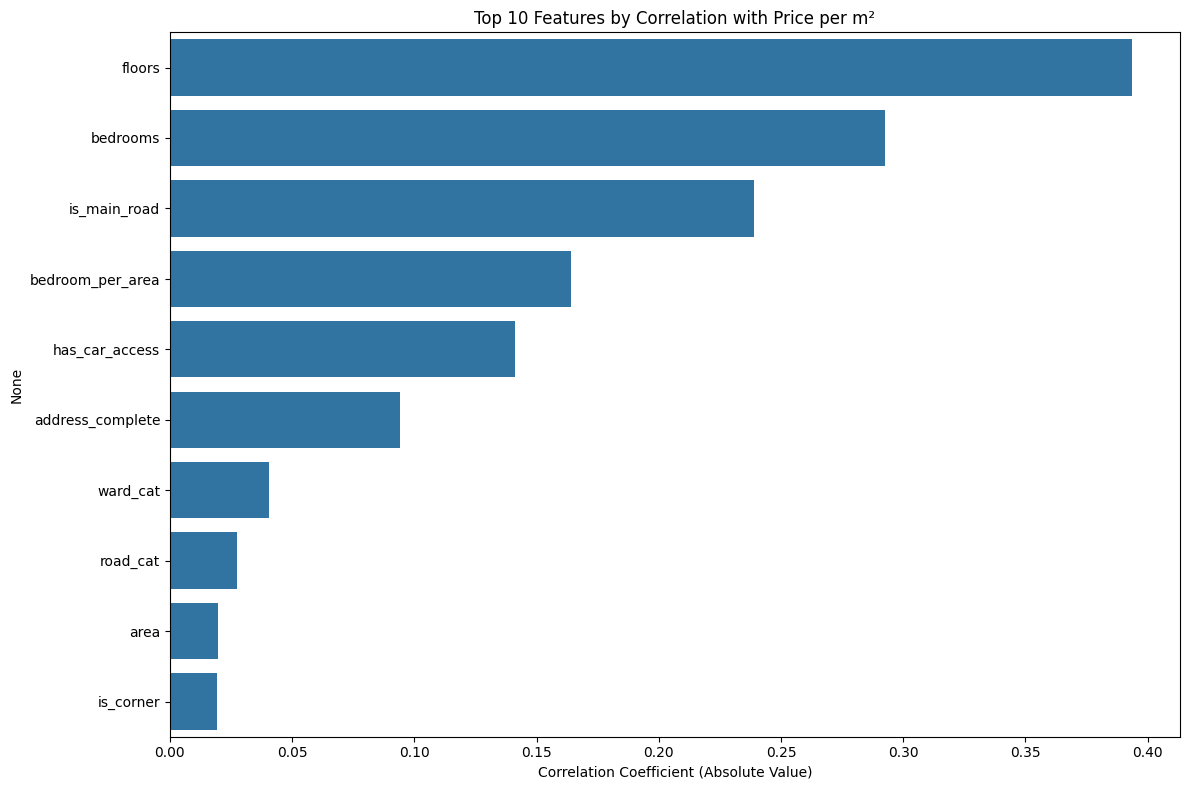

Feature set shape: (14415, 8)
Target shape: (14415,)

Feature set sample:


,area,bedrooms,floors,bedroom_per_area,is_main_road,is_corner,has_car_access,ward_cat
0,80,1,1,0.01,0,0,0,54
1,36,3,6,0.08,0,1,1,157
2,56,1,1,0.02,1,0,0,390
3,32,3,5,0.09,0,1,1,193
4,58,3,3,0.05,0,0,1,313


In [75]:
# Examine correlations with price_per_m2 to inform feature selection
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != 'price_per_m2' and col != 'price' and col != 'price_converted']

# Calculate correlations
correlation_with_target = df[numeric_cols + ['price_per_m2']].corr()['price_per_m2'].sort_values(ascending=False)
print("Correlations with price_per_m2:")
print(correlation_with_target)

# Visualize top correlations
plt.figure(figsize=(12, 8))
correlation_with_target = correlation_with_target.drop('price_per_m2')
top_correlations = correlation_with_target.abs().sort_values(ascending=False).head(10)
sns.barplot(x=top_correlations.values, y=top_correlations.index)
plt.title('Top 10 Features by Correlation with Price per m²')
plt.xlabel('Correlation Coefficient (Absolute Value)')
plt.tight_layout()
plt.show()

# Select relevant features based on correlation analysis
# Numeric features - simplified feature set
numeric_features = ['area', 'bedrooms', 'floors', 'bedroom_per_area', 'is_main_road',
                   'is_corner', 'has_car_access']

# Categorical features - reduced set
categorical_features = ['ward_cat']  # Only use the price category instead of district

# Define features and target
X = df[numeric_features + categorical_features].copy()
y = df['price_per_m2']

print("Feature set shape:", X.shape)
print("Target shape:", y.shape)
print("\nFeature set sample:")
X.head()

## 5. Advanced Data Preprocessing Pipeline

We'll create a more sophisticated preprocessing pipeline with:
1. RobustScaler for numeric features (less sensitive to outliers than StandardScaler)
2. One-hot encoding for categorical features
3. Feature selection using SelectKBest

In [76]:
# Create preprocessing pipelines with modified behavior to prevent overfitting
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Use StandardScaler instead of RobustScaler
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps - simpler pipeline to prevent overfitting
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Display the preprocessing pipeline
print("Preprocessing Pipeline:")
print(preprocessor)

Preprocessing Pipeline:
ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['area', 'bedrooms', 'floors',
                                  'bedroom_per_area', 'is_main_road',
                                  'is_corner', 'has_car_access']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['ward_cat'])])


## 6. Split Data and Prepare for Cross-Validation

In [77]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Define custom scoring metric - negative mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

Training set shape: (11532, 8)
Testing set shape: (2883, 8)


## 7. Enhanced Hyperparameter Tuning 

We'll expand our grid search to include more parameters including distance metrics.

In [83]:
# Create the KNN pipeline with preprocessing
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(f_regression)),  # Feature selection
    ('regressor', KNeighborsRegressor())
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'feature_selection__k': [5, 7, 'all'],  # Number of features to select
    'regressor__n_neighbors': [9, 11, 13, 15, 19, 23, 27, 31, 37, 45],  # Expanded k values
    'regressor__weights': ['uniform', 'distance'],  # Test both weighting options
    'regressor__p': [1, 2],  # Manhattan (p=1) and Euclidean (p=2) distances
    'regressor__leaf_size': [30, 45]  # Leaf size for KD tree or ball tree
}

# Set up GridSearchCV with multiple scoring metrics
scoring = {
    'r2': 'r2', 
    'neg_mean_squared_error': 'neg_mean_squared_error',
    'neg_mean_absolute_error': 'neg_mean_absolute_error'
}

# Build grid search with cross-validation
grid_search = GridSearchCV(
    knn_pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',  # Primary scoring metric
    refit=True,
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV to find optimal parameters
print("Starting grid search - this may take a while...")
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = np.sqrt(-grid_search.best_score_)  # Convert back to RMSE

print(f"\nBest Parameters: {best_params}")
print(f"Best Cross-Validation RMSE: {best_score:.2f} million VND/m²")

# Display the cross-validation results
cv_results = grid_search.cv_results_
results_df = pd.DataFrame({
    'params': cv_results['params'],
    'mean_test_score': np.sqrt(-cv_results['mean_test_score']),  # Convert to RMSE
    'std_test_score': cv_results['std_test_score'],
    'rank_test_score': cv_results['rank_test_score']
})

# Display top 5 parameter combinations
print("\nTop 5 parameter combinations:")
print(results_df.sort_values('rank_test_score').head(5))

# Create the best KNN model
best_knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(f_regression, k=best_params['feature_selection__k'])),
    ('regressor', KNeighborsRegressor(
        n_neighbors=best_params['regressor__n_neighbors'],
        weights=best_params['regressor__weights'],
        p=best_params['regressor__p'],
        leaf_size=best_params['regressor__leaf_size']
    ))
])

# Train the best model
best_knn_pipeline.fit(X_train, y_train)

Starting grid search - this may take a while...
Fitting 5 folds for each of 240 candidates, totalling 1200 fits

Best Parameters: {'feature_selection__k': 'all', 'regressor__leaf_size': 30, 'regressor__n_neighbors': 19, 'regressor__p': 1, 'regressor__weights': 'distance'}
Best Cross-Validation RMSE: 70.11 million VND/m²

Top 5 parameter combinations:
                                                params  mean_test_score  \
217  {'feature_selection__k': 'all', 'regressor__le...            70.11   
177  {'feature_selection__k': 'all', 'regressor__le...            70.11   
181  {'feature_selection__k': 'all', 'regressor__le...            70.18   
221  {'feature_selection__k': 'all', 'regressor__le...            70.18   
225  {'feature_selection__k': 'all', 'regressor__le...            70.29   

     std_test_score  rank_test_score  
217          250.91                1  
177          250.91                1  
181          249.20                3  
221          249.20                3  
2

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['area', 'bedrooms', 'floors',
                                                   'bedroom_per_area',
                                                   'is_main_road', 'is_corner',
                                                   'has_car_access']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['ward_cat'])])),
                ('feature_selection',
                 SelectKBest(k='all',
                             score_func=<function f_regression at 0x7efd8ac135b0>)),
                ('regressor',
                 KNeighborsRegressor(n_neighbors=19, p=1, weights='distance'))])

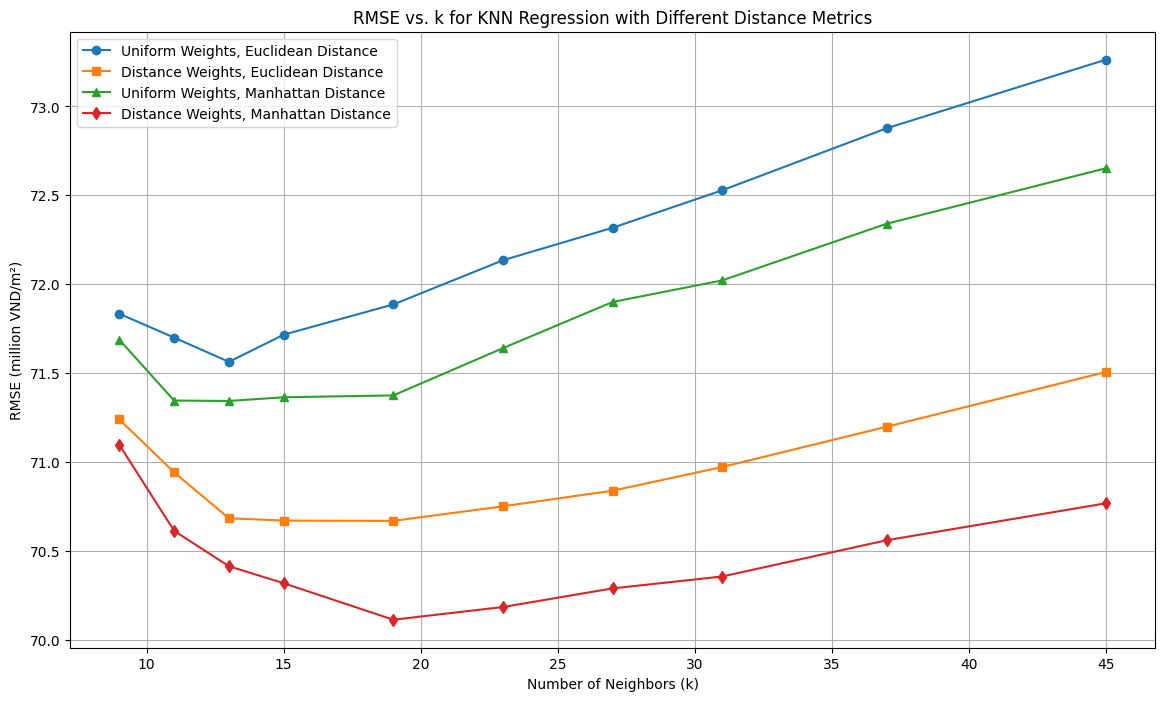

In [84]:
# Plot RMSE vs k to visualize the effect of k using different distance metrics
# Filter results for uniform weights and p=2 (Euclidean)
uniform_euclidean = [params for params in cv_results['params'] 
                   if params['regressor__weights'] == 'uniform' and 
                      params['regressor__p'] == 2 and
                      params['regressor__leaf_size'] == 30 and
                      params['feature_selection__k'] == 'all']
uniform_euclidean_indices = [i for i, params in enumerate(cv_results['params']) 
                           if params in uniform_euclidean]
uniform_euclidean_k = [params['regressor__n_neighbors'] for params in uniform_euclidean]
uniform_euclidean_scores = [np.sqrt(-cv_results['mean_test_score'][i]) for i in uniform_euclidean_indices]

# Filter for distance weights and p=2 (Euclidean)
distance_euclidean = [params for params in cv_results['params'] 
                    if params['regressor__weights'] == 'distance' and
                       params['regressor__p'] == 2 and
                       params['regressor__leaf_size'] == 30 and
                       params['feature_selection__k'] == 'all']
distance_euclidean_indices = [i for i, params in enumerate(cv_results['params']) 
                            if params in distance_euclidean]
distance_euclidean_k = [params['regressor__n_neighbors'] for params in distance_euclidean]
distance_euclidean_scores = [np.sqrt(-cv_results['mean_test_score'][i]) for i in distance_euclidean_indices]

# Filter for uniform weights and p=1 (Manhattan)
uniform_manhattan = [params for params in cv_results['params'] 
                   if params['regressor__weights'] == 'uniform' and
                      params['regressor__p'] == 1 and
                      params['regressor__leaf_size'] == 30 and
                      params['feature_selection__k'] == 'all']
uniform_manhattan_indices = [i for i, params in enumerate(cv_results['params']) 
                           if params in uniform_manhattan]
uniform_manhattan_k = [params['regressor__n_neighbors'] for params in uniform_manhattan]
uniform_manhattan_scores = [np.sqrt(-cv_results['mean_test_score'][i]) for i in uniform_manhattan_indices]

# Filter for distance weights and p=1 (Manhattan)
distance_manhattan = [params for params in cv_results['params'] 
                    if params['regressor__weights'] == 'distance' and
                       params['regressor__p'] == 1 and
                       params['regressor__leaf_size'] == 30 and
                       params['feature_selection__k'] == 'all']
distance_manhattan_indices = [i for i, params in enumerate(cv_results['params']) 
                            if params in distance_manhattan]
distance_manhattan_k = [params['regressor__n_neighbors'] for params in distance_manhattan]
distance_manhattan_scores = [np.sqrt(-cv_results['mean_test_score'][i]) for i in distance_manhattan_indices]

# Plotting
plt.figure(figsize=(14, 8))

# Sort the data by k values for consistent plotting
if uniform_euclidean_k:
    uniform_euclidean_data = sorted(zip(uniform_euclidean_k, uniform_euclidean_scores))
    uniform_euclidean_k, uniform_euclidean_scores = zip(*uniform_euclidean_data)
    plt.plot(uniform_euclidean_k, uniform_euclidean_scores, marker='o', linestyle='-', 
             label='Uniform Weights, Euclidean Distance')

if distance_euclidean_k:
    distance_euclidean_data = sorted(zip(distance_euclidean_k, distance_euclidean_scores))
    distance_euclidean_k, distance_euclidean_scores = zip(*distance_euclidean_data)
    plt.plot(distance_euclidean_k, distance_euclidean_scores, marker='s', linestyle='-', 
             label='Distance Weights, Euclidean Distance')

if uniform_manhattan_k:
    uniform_manhattan_data = sorted(zip(uniform_manhattan_k, uniform_manhattan_scores))
    uniform_manhattan_k, uniform_manhattan_scores = zip(*uniform_manhattan_data)
    plt.plot(uniform_manhattan_k, uniform_manhattan_scores, marker='^', linestyle='-', 
             label='Uniform Weights, Manhattan Distance')

if distance_manhattan_k:
    distance_manhattan_data = sorted(zip(distance_manhattan_k, distance_manhattan_scores))
    distance_manhattan_k, distance_manhattan_scores = zip(*distance_manhattan_data)
    plt.plot(distance_manhattan_k, distance_manhattan_scores, marker='d', linestyle='-', 
             label='Distance Weights, Manhattan Distance')

plt.xlabel('Number of Neighbors (k)')
plt.ylabel('RMSE (million VND/m²)')
plt.title('RMSE vs. k for KNN Regression with Different Distance Metrics')
plt.legend()
plt.grid(True)
plt.show()

## 8. Model Evaluation with Advanced Metrics

In [85]:
# Make predictions
y_train_pred = best_knn_pipeline.predict(X_train)
y_test_pred = best_knn_pipeline.predict(X_test)

# Calculate standard evaluation metrics
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Calculate additional metrics
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

print("Improved KNN Regression Model Performance:")
print(f"Training R² Score: {train_r2:.4f}")
print(f"Testing R² Score: {test_r2:.4f}")
print(f"Training RMSE: {train_rmse:.2f} million VND/m²")
print(f"Testing RMSE: {test_rmse:.2f} million VND/m²")
print(f"Training MAE: {train_mae:.2f} million VND/m²")
print(f"Testing MAE: {test_mae:.2f} million VND/m²")
print(f"Training MAPE: {train_mape:.2f}%")
print(f"Testing MAPE: {test_mape:.2f}%")

Improved KNN Regression Model Performance:
Training R² Score: 0.9838
Testing R² Score: 0.4270
Training RMSE: 11.90 million VND/m²
Testing RMSE: 69.73 million VND/m²
Training MAE: 2.78 million VND/m²
Testing MAE: 51.41 million VND/m²
Training MAPE: 3.41%
Testing MAPE: 540.54%


## 9. Enhanced Visualizations

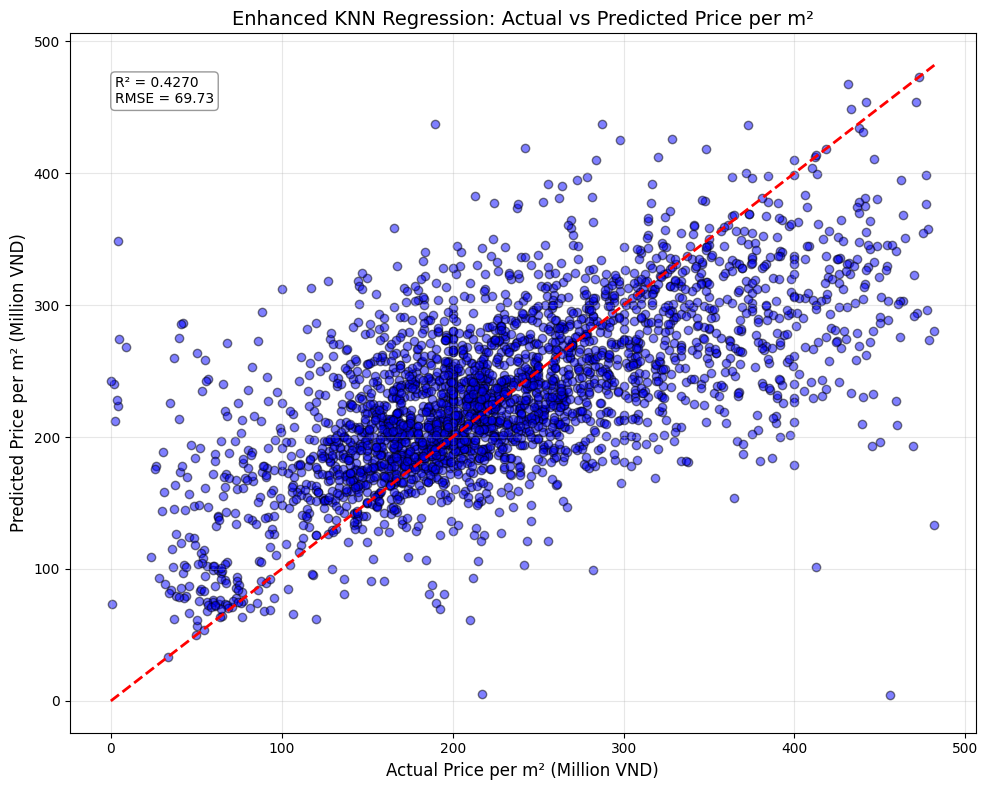

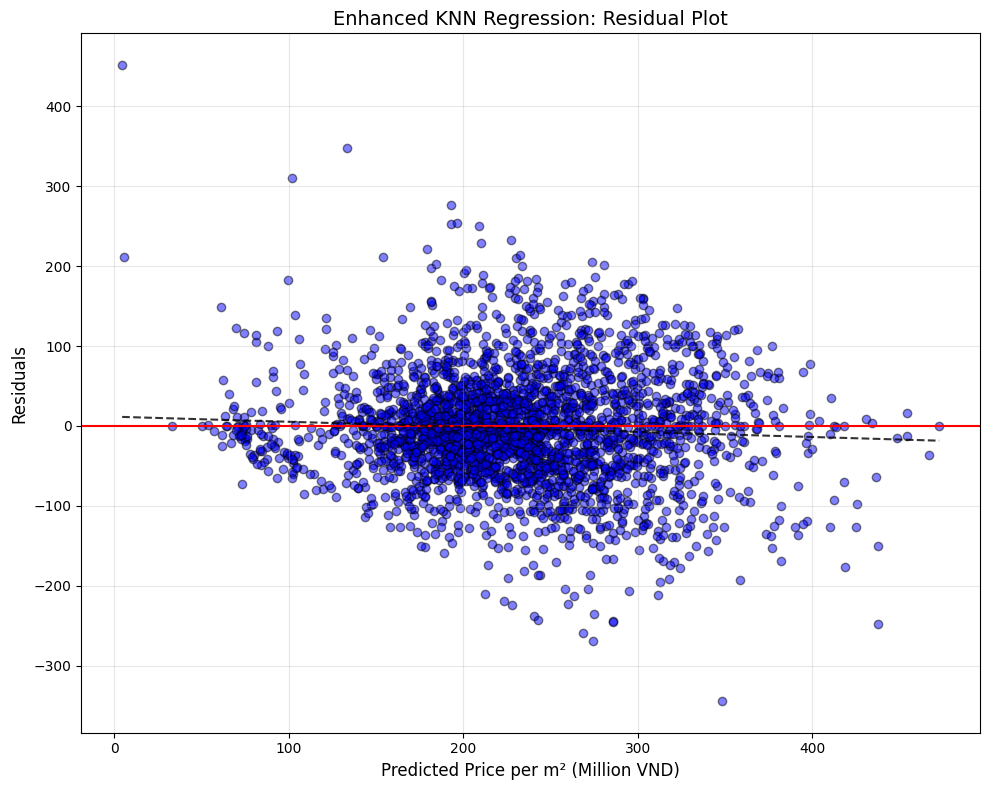

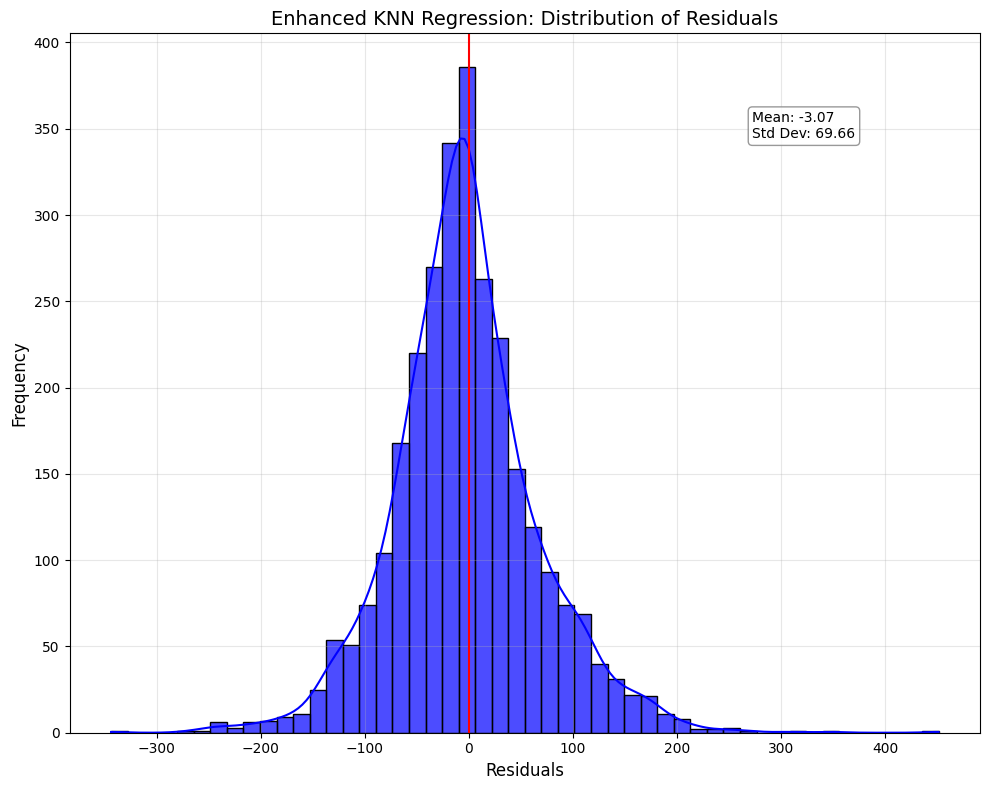

In [81]:
# Visualize predictions vs actual values with improved formatting
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_test_pred, alpha=0.5, c='blue', edgecolors='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual Price per m² (Million VND)', fontsize=12)
plt.ylabel('Predicted Price per m² (Million VND)', fontsize=12)
plt.title('Enhanced KNN Regression: Actual vs Predicted Price per m²', fontsize=14)
plt.grid(True, alpha=0.3)

# Add annotations for R² and RMSE
plt.annotate(f"R² = {test_r2:.4f}\nRMSE = {test_rmse:.2f}", 
             xy=(0.05, 0.9), xycoords='axes fraction', 
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
plt.tight_layout()
plt.show()

# Plot residuals with improved visualization
residuals = y_test - y_test_pred
plt.figure(figsize=(10, 8))
plt.scatter(y_test_pred, residuals, alpha=0.5, c='blue', edgecolors='k')
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted Price per m² (Million VND)', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title('Enhanced KNN Regression: Residual Plot', fontsize=14)
plt.grid(True, alpha=0.3)

# Add trend line for residuals
z = np.polyfit(y_test_pred, residuals, 1)
p = np.poly1d(z)
plt.plot(np.sort(y_test_pred), p(np.sort(y_test_pred)), "k--", alpha=0.8)
plt.tight_layout()
plt.show()

# Histogram of residuals with KDE and improved formatting
plt.figure(figsize=(10, 8))
sns.histplot(residuals, kde=True, bins=50, color='blue', alpha=0.7)
plt.xlabel('Residuals', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Enhanced KNN Regression: Distribution of Residuals', fontsize=14)
plt.grid(True, alpha=0.3)
plt.axvline(x=0, color='r', linestyle='-')

# Annotate with statistics
plt.annotate(f"Mean: {np.mean(residuals):.2f}\nStd Dev: {np.std(residuals):.2f}", 
             xy=(0.75, 0.85), xycoords='axes fraction', 
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
plt.tight_layout()
plt.show()